In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Carga del DataSet
data = pd.read_csv("../Data/bank-additional-full.csv", sep = ";")
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [125]:
# Verificación de balance de clases
data.y.value_counts(normalize = True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

# Preparación del dataset

## Preparación en train y test

In [5]:
# Selección de variable targuet
y = data.y
# Selección de features
X = data.drop(["y"], axis = 1)

In [6]:
from sklearn.model_selection import train_test_split

# Separació en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 161, stratify= y)

In [7]:
# Verificación de distribución de variable targuet en train y test
display(y_train.value_counts(normalize=True))
display(y_test.value_counts(normalize=True))

no     0.887344
yes    0.112656
Name: y, dtype: float64

no     0.887351
yes    0.112649
Name: y, dtype: float64

In [8]:
from sklearn import preprocessing

# Transformación de variable targuet categórica en numérica
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

**Data train y test con undersampling**

In [134]:
# Balanceado de clases de target con RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy= 0.3 ,random_state=123); # iguala las clases
X_train_us,y_train_us = undersampler.fit_resample(X_train,y_train)

print("Balance de targuet después de undersampling \n",pd.DataFrame(y_train_us).value_counts(normalize = True))

# Selección de la data de train y test en tipo numérica y categórica
X_train_numerical_us = X_train_us.select_dtypes(exclude = "object")
X_test_numerical_us = X_test.select_dtypes(exclude = "object")

X_train_categorical_us = X_train_us.select_dtypes(include='object')
X_test_categorical_us = X_test.select_dtypes(include='object')

# Transformación de data de train y test categórica en numérica con OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown = "ignore", sparse = False)
X_train_categorical_us_OH =  pd.DataFrame (OH_encoder.fit_transform(X_train_categorical_us))
X_train_categorical_us_OH.index = X_train_categorical_us.index

X_test_categorical_us_OH = pd.DataFrame (OH_encoder.transform(X_test_categorical_us))
X_test_categorical_us_OH.index = X_test_categorical_us.index

#Estandarización de variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_numerical_us_std = pd.DataFrame(sc_X.fit_transform(X_train_numerical_us))
X_train_numerical_us_std.index = X_train_numerical_us.index

X_test_numerical_us_std = pd.DataFrame(sc_X.transform(X_test_numerical_us))
X_test_numerical_us_std.index = X_test_numerical_us.index

# Concatenación de data numerica con categórica transformada con OneHotEncoder sin estandarizar
X_train_us = pd.concat([X_train_numerical_us, X_train_categorical_us_OH], axis = 1)
X_test_us = pd.concat([X_test_numerical_us, X_test_categorical_us_OH], axis = 1)

# Concatenación de data numerica con categórica transformada con OneHotEncoder estandarizada
X_train_us_std = pd.concat([X_train_numerical_us_std, X_train_categorical_us_OH], axis = 1)
X_test_us_std = pd.concat([X_test_numerical_us_std, X_test_categorical_us_OH], axis = 1)

Balance de targuet despues de undersampling 
 0    0.769226
1    0.230774
dtype: float64


## **F2 Score**

In [10]:
from sklearn.metrics import make_scorer, fbeta_score

In [11]:
# Creacion de score f2 
ftwo_scorer = make_scorer(fbeta_score, beta=2)

## **Regresión Logística con regularización**

In [47]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, fbeta_score, make_scorer, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [48]:
# Seteado de grid search
k_range = np.logspace(-4, 4, 20)
logreg = LogisticRegression(max_iter = 1e3)
param_grid = {'C': k_range}
k_fold =  StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

#Instanciado de GridSearchCV
gridlogreg = GridSearchCV ( logreg, param_grid, cv = k_fold, verbose=0, scoring = ftwo_scorer)

# Fiteado del modelo de regresión logistica con grid search
gridlogreg = gridlogreg.fit(X_train_us_std,y_train_us)

print(gridlogreg.best_estimator_)
print("La media del f2 score del modelo es:", gridlogreg.best_score_)
print("El mejor hiperparametro C del modelo es: ", gridlogreg.best_params_)

LogisticRegression(C=78.47599703514607, max_iter=1000.0)
La media del f2 score del modelo es: 0.6740707027530043
El mejor hiperparametro C del modelo es:  {'C': 78.47599703514607}


In [50]:
from sklearn.linear_model import LogisticRegression
# Fiteado de modelo de regresion logistica con mejor hiperparametro C
best_hip = 78.47599703514607
logmodel = LogisticRegression( C = best_hip, max_iter=1e3) 
logmodel.fit(X_train_us_std,y_train_us)

LogisticRegression(C=78.47599703514607, max_iter=1000.0)

In [51]:
logpredtrain = logmodel.predict(X_train_us_std)
logpredtest = logmodel.predict(X_test_us_std)

# Creación de las variables score para la posterior evaluación de modelos
LG_ftwo_train = ftwo_scorer(logmodel,X_train_us_std,y_train_us)
LG_ftwo_test = ftwo_scorer(logmodel,X_test_us_std,y_test)

LG_fone_train = f1_score(y_train_us, logpredtrain)
LG_fone_test = f1_score(y_test, logpredtest)

LG_accuracy_train = accuracy_score(y_train_us, logpredtrain)
LG_accuracy_test = accuracy_score(y_test, logpredtest)

LG_ROC_train = roc_auc_score(y_train_us, logpredtrain)
LG_ROC_test = roc_auc_score(y_test, logpredtest)

LG_recall_train = recall_score(y_train_us, logpredtrain)
LG_recall_test = recall_score(y_test, logpredtest)


print(confusion_matrix(y_train_us, logpredtrain))
print(confusion_matrix(y_test, logpredtest))
print(LG_ftwo_train)
print(LG_ftwo_test)

[[11649   724]
 [ 1253  2459]]
[[6866  444]
 [ 315  613]]
0.6818812045920912
0.6426923883413713


## **KNN**

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [20]:
# Seteado de Grid Search
knn = KNeighborsClassifier()
k_range = list(range(1, 31, 2))
param_grid = dict(n_neighbors=k_range)
folds=StratifiedKFold(n_splits=3, random_state=19, shuffle=True)

#Instanciado de GridSearchCV
gridknn = GridSearchCV(knn, param_grid, cv=folds, scoring=ftwo_scorer)

# Fiteado del modelo de regresión logistica con grid search
gridknn.fit(X_train_us_std, y_train_us)

print(gridknn.best_estimator_)
print("La media del f2 score del modelo es:", gridknn.best_score_)
print("El mejor hiperparametro n_neighbors del modelo es: ", gridknn.best_params_)

KNeighborsClassifier(n_neighbors=9)
La media del f2 score del modelo es: 0.6568895298275658
El mejor hiperparametro n_neighbors del modelo es:  {'n_neighbors': 9}


In [52]:
# Fiteado de modelo de knn con mejor hiperparametro n_neighbors
best_hip = 9
knnmodel = KNeighborsClassifier( n_neighbors = best_hip) 
knnmodel.fit(X_train_us_std,y_train_us)

KNeighborsClassifier(n_neighbors=9)

In [53]:
knnpredtrain = knnmodel.predict(X_train_us_std)
knnpredtest = knnmodel.predict(X_test_us_std)

# Creación de las variables score para la posterior evaluación de modelos
KNN_ftwo_train = ftwo_scorer(knnmodel,X_train_us_std,y_train_us)
KNN_ftwo_test = ftwo_scorer(knnmodel,X_test_us_std,y_test)

KNN_fone_train = f1_score(y_train_us, knnpredtrain)
KNN_fone_test = f1_score(y_test, knnpredtest)

KNN_accuracy_train = accuracy_score(y_train_us, knnpredtrain)
KNN_accuracy_test = accuracy_score(y_test, knnpredtest)

KNN_ROC_train = roc_auc_score(y_train_us, knnpredtrain)
KNN_ROC_test = roc_auc_score(y_test, knnpredtest)

KNN_recall_train = recall_score(y_train_us, knnpredtrain)
KNN_recall_test = recall_score(y_test, knnpredtest)


print(confusion_matrix(y_train_us, knnpredtrain))
print(confusion_matrix(y_test, knnpredtest))
print(KNN_ftwo_train)
print(KNN_ftwo_test)

[[11614   759]
 [ 1071  2641]]
[[6762  548]
 [ 326  602]]
0.7236409469530907
0.6190867955573837


## **Naive Bayes**

In [54]:
from sklearn.naive_bayes import GaussianNB
# Fiteado de modelo Naive Bayes
gaussiannb = GaussianNB()
gaussiannb.fit(X_train_us_std, y_train_us)

GaussianNB()

In [55]:
gaussiannbpredtrain = gaussiannb.predict(X_train_us_std)
gaussianpredtest = gaussiannb.predict(X_test_us_std)

# Creación de las variables score para la posterior evaluación de modelos
GAU_ftwo_train = ftwo_scorer(gaussiannb,X_train_us_std,y_train_us)
GAU_ftwo_test = ftwo_scorer(gaussiannb,X_test_us_std,y_test)

GAU_fone_train = f1_score(y_train_us, gaussiannbpredtrain)
GAU_fone_test = f1_score(y_test, gaussianpredtest)

GAU_accuracy_train = accuracy_score(y_train_us, gaussiannbpredtrain)
GAU_accuracy_test = accuracy_score(y_test, gaussianpredtest)

GAU_ROC_train = roc_auc_score(y_train_us, gaussiannbpredtrain)
GAU_ROC_test = roc_auc_score(y_test, gaussianpredtest)

GAU_recall_train = recall_score(y_train_us, gaussiannbpredtrain)
GAU_recall_test = recall_score(y_test, gaussianpredtest)

print(confusion_matrix(y_train_us, gaussiannbpredtrain))
print(confusion_matrix(y_test, gaussianpredtest))
print(GAU_ftwo_train)
print(GAU_ftwo_test)

[[10069  2304]
 [ 1115  2597]]
[[5927 1383]
 [ 282  646]]
0.6575016456529443
0.5626197526563317


## **Decision TreeClassifier**

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from IPython.display import Image
import pydotplus
from sklearn.tree import DecisionTreeClassifier

In [42]:
# Seteado de parametros de Grid Search
clftree = tree.DecisionTreeClassifier(random_state=40)
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [20,50,100], 
                "max_depth" : [1,2,3,4,5,6,8,10,15],
                "min_samples_split": [1,5,10,20,50,100,300,800]}
k_folds=StratifiedKFold(n_splits=5, random_state=19, shuffle=True)
# Instanciado de modelo con GridSearchCV
grid_search = GridSearchCV(clftree, params_grid, n_jobs=-1, cv = k_folds, scoring= ftwo_scorer)
# Fiteado de modelo con GridSearchCV
grid_search.fit(X_train_us, y_train_us)

print(grid_search.best_estimator_)
print("La media del f2 score del modelo es:", grid_search.best_score_)
print("El mejor hiperparametro n_neighbors del modelo es: ", grid_search.best_params_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=100,
                       random_state=40)
La media del f2 score del modelo es: 0.7616547951308353
El mejor hiperparametro n_neighbors del modelo es:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 100}


In [43]:
# Fiteado del modelo con hiperparametros obtenidos con Grid Search
dtree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=100,
                       random_state=40)
dtree.fit(X_train_us, y_train_us)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=100,
                       random_state=40)

In [44]:
# Obtencion de score del modelo
dtreepredtrain = dtree.predict(X_train_us)
dtreepredtest = dtree.predict(X_test_us)

# Creación de las variables score para la posterior evaluación de modelos
DTREE_ftwo_train = ftwo_scorer(dtree,X_train_us,y_train_us)
DTREE_ftwo_test = ftwo_scorer(dtree,X_test_us,y_test)

DTREE_fone_train = f1_score(y_train_us, dtreepredtrain)
DTREE_fone_test = f1_score(y_test, dtreepredtest)

DTREE_accuracy_train = accuracy_score(y_train_us, dtreepredtrain)
DTREE_accuracy_test = accuracy_score(y_test, dtreepredtest)

DTREE_ROC_train = roc_auc_score(y_train_us, dtreepredtrain)
DTREE_ROC_test = roc_auc_score(y_test, dtreepredtest)

DTREE_recall_train = recall_score(y_train_us, dtreepredtrain)
DTREE_recall_test = recall_score(y_test, dtreepredtest)


print(confusion_matrix(y_train_us, dtreepredtrain))
print(confusion_matrix(y_test, dtreepredtest))
print(DTREE_ftwo_train)
print(DTREE_ftwo_test)

[[11421   952]
 [  700  3012]]
[[6685  625]
 [ 233  695]]
0.8005528386136508
0.6905802861685213


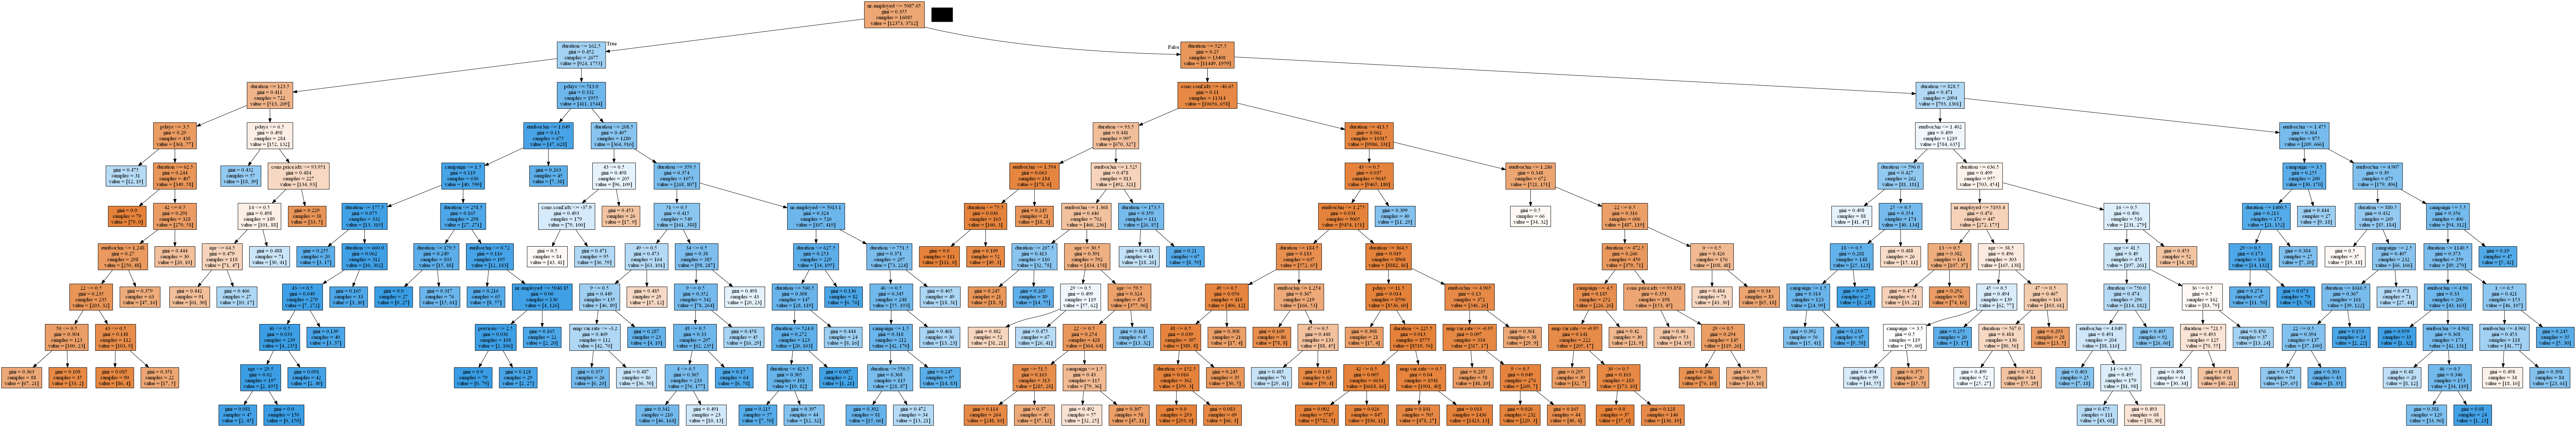

In [124]:
# Ploteo de arbol de decisión
dot_data = tree.export_graphviz(dtree, out_file=None,feature_names= X_train_us.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

# **Comparación de los modelos**

In [120]:
models = pd.DataFrame({'Models': ['Logistic Model', 'K-Near Neighbors',
                                   'Gausian NB', 'Decision Tree Classifier'],
                       'F2 Score Train':  [LG_ftwo_train, KNN_ftwo_train, GAU_ftwo_train, DTREE_ftwo_train],
                       'F2 Score Test': [LG_ftwo_test, KNN_ftwo_test, GAU_ftwo_test, DTREE_ftwo_test],
                       'F1 Score Train':  [LG_fone_train, KNN_fone_train, GAU_fone_train, DTREE_fone_train],
                       'F1 Score Test': [LG_fone_test, KNN_fone_test, GAU_fone_test, DTREE_fone_test],                       
                       'Accuracy Score Train':  [LG_accuracy_train, KNN_accuracy_train, GAU_accuracy_train, DTREE_accuracy_train],
                       'Accuracy Score Test': [LG_accuracy_test, KNN_accuracy_test, GAU_accuracy_test, DTREE_accuracy_test],
                       'ROC AUC Score Train':  [LG_ROC_train, KNN_ROC_train, GAU_ROC_train, DTREE_ROC_train],
                       'ROC AUC Score Test': [LG_ROC_test, KNN_ROC_test, GAU_ROC_test, DTREE_ROC_test],
                       'Recall Score Train':  [LG_recall_train, KNN_recall_train, GAU_recall_train, DTREE_recall_train],
                       'Recall Score Test': [LG_recall_test, KNN_recall_test, GAU_recall_test, DTREE_recall_test]})
        
models.sort_values(by='F2 Score Test', ascending=False)

,Models,F2 Score Train,F2 Score Test,F1 Score Train,F1 Score Test,Accuracy Score Train,Accuracy Score Test,ROC AUC Score Train,ROC AUC Score Test,Recall Score Train,Recall Score Test
3,Decision Tree Classifier,0.800553,0.690580,0.784784,0.618327,0.897296,0.895849,0.867240,0.831712,0.811422,0.748922
0,Logistic Model,0.681881,0.642692,0.713270,0.617632,0.877090,0.907866,0.801966,0.799911,0.662446,0.660560
1,K-Near Neighbors,0.723641,0.619087,0.742688,0.579403,0.886229,0.893906,0.825067,0.786871,0.711476,0.648707
2,Gausian NB,0.657502,0.562620,0.603042,0.436929,0.787442,0.797888,0.756705,0.753464,0.699623,0.696121


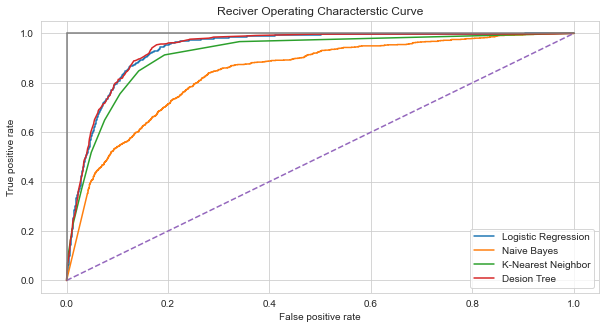

In [58]:
# Obtencion de predicciones para graficar curva ROC
probsdtree = dtree.predict_proba(X_test_us)
predsdtree = probsdtree[:,1]

probslog = logmodel.predict_proba(X_test_us_std)
predslog = probslog[:,1]

probsknn = knnmodel.predict_proba(X_test_us_std)
predsknn = probsknn[:,1]

probsgauss = gaussiannb.predict_proba(X_test_us_std)
predsgauss = probsgauss[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predslog)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,predsgauss)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,predsknn)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,predsdtree)

# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Decision Tree')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

# *Decision Tree Classifier presentó la mejor performance frente al problema de clasificación*
**En las métricas utilizadas para medir la performance de los modelos, el decision tree classifier superó al resto, obteniendo mejor score especialmente en f2 score que fue la elegida para optimizar los hiperparámetros**

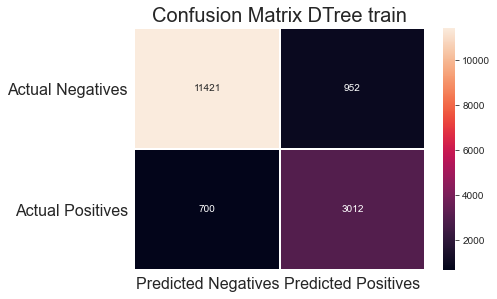

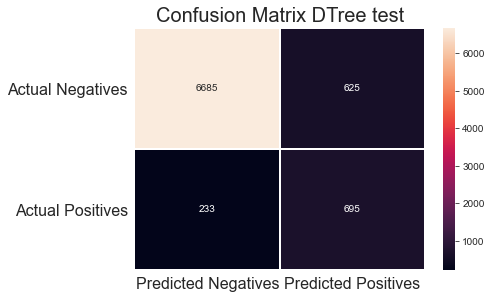

In [119]:
from sklearn.metrics import confusion_matrix

# Matriz de confusión para modelo seleccionado
conf_matrix = confusion_matrix(y_train_us, dtreepredtrain)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix DTree train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Predicted Negatives', 'Predicted Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test, dtreepredtest)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix DTree test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Predicted Negatives', 'Predicted Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()